# Прогнозирование оттока клиентов банка

[Описание данных](#Описание-данных)

[Изучение общей информации](#Изучение-общей-информации)

[Подготовка данных](#Подготовка-данных)

[Исследование задачи](#Исследование-задачи)

[Борьба с дисбалансом](#Борьба-с-дисбалансом)

[Тестирование модели](#Тестирование-модели)

# Изучение общей информации 

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

data = pd.read_csv('/datasets/Churn.csv')
# print(data)
# print(data.info())
# print('==============================')

def info(data): # Функция пробегает по признакам датафрейма и оценивает распределение

    for column in data.columns:       
            import plotly.express as px
            print(data[column].describe())
            fig = px.histogram(data, x = column, marginal = 'box', title = 'Распределение '+ column)
            fig.show()
            
# info(data)

## Вывод

Таблица открыта и изучена. Таблица имеет 10000 строк и 14 столбцов. Визуальное изучение таблицы показало множество пропущенных значений. Использовали describe() и unique() для категориальных переменных, что позволило нам оценить распределение некоторых признаков и увидеть аномалии.

# Подготовка данных

In [2]:
tenure_median = data['Tenure'].median()
data['Tenure'] = data['Tenure'].fillna(tenure_median) # заполняем медианным значением 
my_data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1) # исключаем из дальнейшего исследования  
print(data.isnull().sum())
print(my_data.info())
encoder = OrdinalEncoder() # проводим кодирование категориальных признаков
data_ordinal = pd.DataFrame(encoder.fit_transform(my_data), columns=my_data.columns) # проводим кодирование категориальных признаков

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB
None


# Исследование задачи

## Исследование баланса классов

In [3]:
my_data.Exited.value_counts( )

0    7963
1    2037
Name: Exited, dtype: int64

## Разделение данных на выборки 

In [4]:
y = data_ordinal['Exited']

data_train, data_temp = train_test_split(data_ordinal, test_size = 0.4, random_state=12345, stratify = y) # Разбили исходный df на тренировочную 60% и временную выборки 40%
data_valid, data_test = train_test_split(data_temp, test_size = 0.5, random_state=12345) # Разбили временную выборку на тестовую и валидационную 50\50

features_train = data_train.drop(['Exited'], axis=1)
target_train = data_train['Exited']

print(features_train.shape)
print(target_train.shape)

features_valid = data_valid.drop(['Exited'], axis=1)
target_valid = data_valid['Exited']

print(features_valid.shape)
print(target_valid.shape)

features_test = data_test.drop(['Exited'], axis=1)
target_test = data_test['Exited']

print(features_test.shape)
# print(features_test.head(10))
print(target_test.shape)
print(target_test.head(10))

(6000, 10)
(6000,)
(2000, 10)
(2000,)
(2000, 10)
(2000,)
8035    0.0
369     0.0
3812    0.0
5949    1.0
5788    1.0
7487    1.0
6036    0.0
3278    0.0
1222    0.0
4557    0.0
Name: Exited, dtype: float64


## Масштабирование признаков

In [5]:
# numeric = ['CreditScore', 'Tenure', 'Balance', 'Age','NumOfProducts', 'EstimatedSalary']
# scaler = StandardScaler()
# scaler.fit(features_train[numeric])
# pd.options.mode.chained_assignment = None
# features_train[numeric] = scaler.transform(features_train[numeric])
# features_valid[numeric] = scaler.transform(features_valid[numeric])
# print(features_train.head())

## Исследование моделей

In [6]:
#Изучение моделей без учёта дисбаланса
# Дерево решений

result_tree = 0
tree_depth = 0

for depth in range(1, 20, 1):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    # инициализировали модель DecisionTreeClassifier с параметром random_state=12345 и max_depth=depth
    model_tree.fit(features_train, target_train) # обучаем модель на тренировочной выборке
    predictions_valid = model_tree.predict(features_valid) # получаем предсказания модели на валидационной выборке
    accuracy_tree = accuracy_score(target_valid, predictions_valid)
    
    if accuracy_tree > result_tree:
        result_tree = accuracy_tree
        tree_depth = depth

print("Глубина дерева:", tree_depth)
print("Доля правильных ответов:", result_tree)
print(model_tree.score(features_valid, target_valid))
print("F1 - мера:", f1_score(target_valid, predictions_valid))

Глубина дерева: 7
Доля правильных ответов: 0.8595
0.7925
F1 - мера: 0.4857496902106567


In [7]:
# Cлучайный лес

result_forest = 0
estimators = 0

for n in range(1, 20, 1):
    model_forest = RandomForestClassifier(random_state=12345, max_depth=n, n_estimators = n, min_samples_leaf = n) 
    model_forest.fit(features_train, target_train) # обучаем модель на тренировочной выборке
    result = model_forest.score(features_valid, target_valid) # считаем качество модели на валидационной выборке
    predictions_valid = model_forest.predict(features_valid) # получаем предсказания модели на валидационной выборке
    accuracy_forest = accuracy_score(target_valid, predictions_valid)
    if result > result_forest:
        result_forest = result #  сохраняем наилучшее значение метрики accuracy на валидационных данных
        estimators = n
        
print("Количество деревьев:", estimators)
print('Доля правильных ответов:', accuracy_forest)
print("Accuracy наилучшей модели на валидационной выборке:", result_forest)
print(model_forest.score(features_valid, target_valid))
print("F1 - мера:",f1_score(target_valid, predictions_valid))

Количество деревьев: 17
Доля правильных ответов: 0.862
Accuracy наилучшей модели на валидационной выборке: 0.866
0.862
F1 - мера: 0.5415282392026578


In [8]:
# Логистическая регрессия
model_regression = LogisticRegression(random_state=12345, solver='liblinear') # инициализируем модель LogisticRegression
model_regression.fit(features_train, target_train) # обучаем модель на тренировочной выборке
result_regression = model_regression.score(features_valid, target_valid) # считаем качество модели на валидационной выборке
predictions_valid = model_regression.predict(features_valid)
print(result_regression)
print(model_regression.score(features_valid, target_valid))
print("F1 - мера:", f1_score(target_valid, predictions_valid))

0.8105
0.8105
F1 - мера: 0.24652087475149104


## Вывод

По результатам исследования моделей без учёта дисбаланса классов наибольшее значение F1-меры показала модель "Случайный лес".

# Борьба с дисбалансом

In [9]:
# Увеличение выборки (Upsampling)
from sklearn.utils import shuffle

def upsample(features, target, repeat):
    features_zeros = features_train[target_train == 0] #признаки объектов с ответом «0»;
    features_ones = features_train[target_train == 1] #признаки объектов с ответом «1»;
    target_zeros = target_train[target_train == 0]  #целевой признак объектов, у которых ответы только «0»;
    target_ones = target_train[target_train == 1] #целевой признак объектов, у которых ответы только «1».

    features_upsampled = shuffle(pd.concat([features_zeros] + [features_ones] * repeat))
    target_upsampled = shuffle(pd.concat([target_zeros] + [target_ones] * repeat))
  
    return features_upsampled, target_upsampled     


features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

print(features_upsampled.shape)
print(target_upsampled.shape)

(8444, 10)
(8444,)


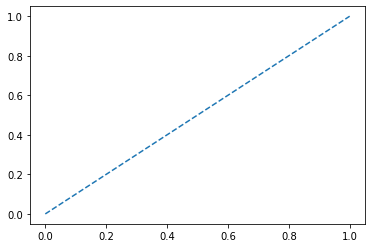

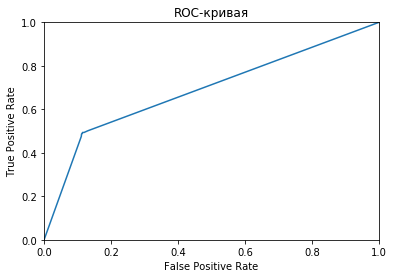

Глубина дерева: 3
Accuracy: 0.8125
0.8085
F1 - мера: 0.5019505851755526
AUC-ROC: 0.6886606508466602


In [10]:
# Дерево решений

result_tree = 0
tree_depth = 0

for depth in range(1, 20, 1):
    model_tree = DecisionTreeClassifier(class_weight='balanced', random_state=12345, max_depth=depth)
    #     model_tree.fit(features_upsampled, target_upsampled) 
    model_tree.fit(features_train, target_train)
    predictions_valid = model_tree.predict(features_valid) 
    accuracy_tree = accuracy_score(target_valid, predictions_valid)
    
    if accuracy_tree > result_tree:
        result_tree = accuracy_tree
        tree_depth = depth


probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели 
plt.figure()
plt.plot(fpr, tpr) # < строим график >
plt.ylim([0.0, 1.0]) # < применяем функции plt.xlim() и plt.ylim(), чтобы
plt.xlim([0.0, 1.0]) #   установить границы осей от 0 до 1 >
plt.xlabel('False Positive Rate') # < применяем функции plt.xlabel() и plt.ylabel(), чтобы
plt.ylabel('True Positive Rate') #   подписать оси "False Positive Rate" и "True Positive Rate" >
plt.title('ROC-кривая') # < добавляем к графику заголовок "ROC-кривая" функцией plt.title() >
plt.show() 

print("Глубина дерева:", tree_depth)
print("Accuracy:", result_tree)
print(model_tree.score(features_valid, target_valid))
print("F1 - мера:", f1_score(target_valid, predictions_valid))
print("AUC-ROC:", auc_roc)

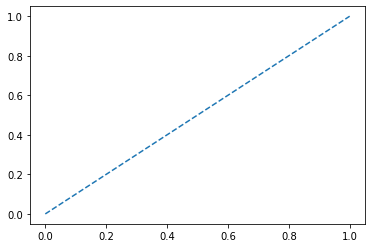

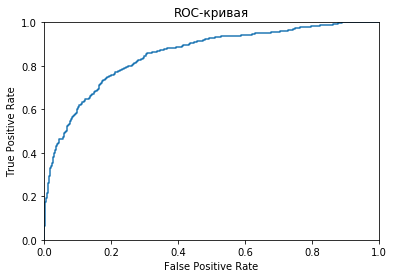

Количество деревьев: 2
Accuracy наилучшей модели на валидационной выборке: 0.8375
0.812
F1 - мера: 0.5974304068522485
AUC-ROC: 0.8533616056739664


In [11]:
# Cлучайный лес

result_forest = 0
estimators = 0

for n in range(1, 20, 1):
    model_forest = RandomForestClassifier(class_weight='balanced', random_state=12345, max_depth=depth, n_estimators = n, min_samples_leaf = n) 
#     model_forest.fit(features_upsampled, target_upsampled) 
    model_forest.fit(features_train, target_train)
    result = model_forest.score(features_valid, target_valid) 
    predictions_valid = model_forest.predict(features_valid) 
#     accuracy_forest = accuracy_score(target_valid, predictions_valid)
    if result > result_forest:
        result_forest = result 
        estimators = n
        
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--') 
plt.figure()
plt.plot(fpr, tpr) 
plt.ylim([0.0, 1.0]) 
plt.xlim([0.0, 1.0]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC-кривая') 
plt.show()        
        
print("Количество деревьев:", estimators)
print("Accuracy наилучшей модели на валидационной выборке:", result_forest)
print(model_forest.score(features_valid, target_valid))
print("F1 - мера:", f1_score(target_valid, predictions_valid))
print("AUC-ROC:", auc_roc)

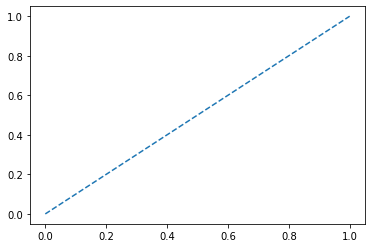

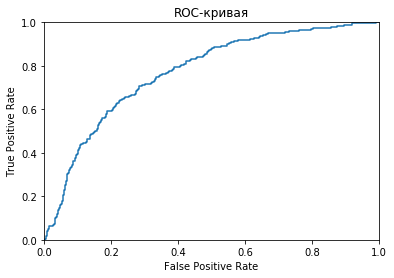

0.704
F1- мера: 0.48521739130434777
AUC-ROC: 0.7702628596497642


In [12]:
# Логистическая регрессия

model_regression = LogisticRegression(class_weight='balanced', random_state=12345, solver='liblinear') 
model_regression.fit(features_train, target_train) 
# model_regression.fit(features_upsampled, target_upsampled)
predicted_valid = model_regression.predict(features_valid)
probabilities_valid = model_regression.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--') 
plt.figure()
plt.plot(fpr, tpr) 
plt.ylim([0.0, 1.0]) 
plt.xlim([0.0, 1.0]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC-кривая') 
plt.show()
    
print(model_regression.score(features_valid, target_valid))
print("F1- мера:", f1_score(target_valid, predicted_valid))
print("AUC-ROC:", auc_roc)

## Вывод 

* По результатам исследования моделей с учётом дисбаланса классов наилучшим образом себя показала модель "Cлучайный лес". У этой модели наиболее высокий показатель F1- меры, а также высокий показатель AUC-ROC.
* Масштабирование повлияло в положительную сторону только на показатели моделей "Логистическая регрессия", как без учёта дисбаланса, так и с учётом. Поэтому для дальнейшего тестирования лучшей модели принято решение закомментировать масштабирование.
* Увеличение выборки (upsampling) в нашем случае не оказало решающего действия в связи с чем не было использовано для финального тестирования наилучшей модели.

# Тестирование модели

Доля правильных ответов: 0.825
F1 - мера: 0.6119733924611972
AUC-ROC: 0.8551219351594674


'Feature ranking:'

1. feature 3 (0.331724)
2. feature 6 (0.180171)
3. feature 5 (0.131918)
4. feature 9 (0.084589)
5. feature 0 (0.082850)
6. feature 8 (0.060561)
7. feature 4 (0.045231)
8. feature 1 (0.044924)
9. feature 2 (0.025645)
10. feature 7 (0.012386)


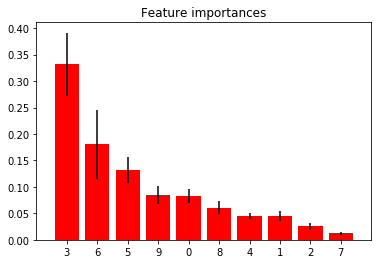

In [13]:
# Cлучайный лес
model_forest = RandomForestClassifier(class_weight='balanced', random_state=12345, max_depth=19, n_estimators = 9, min_samples_leaf = 9)
model_forest.fit(features_train, target_train)
predictions_forest_test = model_forest.predict(features_test)
accuracy_forest = accuracy_score(target_test, predictions_forest_test)
probabilities_test = model_forest.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print("Доля правильных ответов:", accuracy_forest)
print("F1 - мера:", f1_score(target_test, predictions_forest_test))
print("AUC-ROC:", auc_roc)


def feature_scoring(scoring_model, features_data): # передаем в функцию тренированную модель и набор фичей 
    importances = scoring_model.feature_importances_ # присваиваем модели массив показателей важности признаков
    std = np.std([tree.feature_importances_ for tree in scoring_model.estimators_], # вычисляем массив стандартных отклонений
             axis=0)
    indices = np.argsort(importances)[::-1] # сортируем и ревертим массив показателей важности

#     print(features_data.info())
    display("Feature ranking:")

    for f in range(features_data.shape[1]): 
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]])) # выводим важность признака для каждой фичи

    # Изобразим на графике важность признаков
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(features_data.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(features_data.shape[1]), indices)
    plt.xlim([-1, features_data.shape[1]])
    plt.show()

feature_scoring(model_forest, features_train)

## Вывод  

График показывает, что параметр "Age" сильно влияет на нашу модель, и при сборе данных нужно уделить ему внимание, от него зависит успешность предсказаний, а значит и успешность бизнеса. 